In [1]:
# Let's import the dependencies

import os
import pickle
import random
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from transformers import BertTokenizer, TFBertModel
from official.nlp import optimization
import matplotlib.pyplot as plt

d:\Conda\envs\GPU\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\Conda\envs\GPU\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
d:\Conda\envs\GPU\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not

In [2]:
# Class for loading image and text data


class ITM_DataLoader:
    BATCH_SIZE = 16
    IMAGE_SIZE = (224, 224)
    IMAGE_SHAPE = (224, 224, 3)
    MAX_SENTENCE_LENGTH = 50
    SENTENCE_EMBEDDING_SHAPE = 384
    AUTOTUNE = tf.data.AUTOTUNE
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    DATA_PATH = "D:/_GITHUB_/Image-Text-Matching/data"
    IMAGES_PATH = DATA_PATH + "/images"
    train_data_file = DATA_PATH + "/flickr8k.TrainImages.txt"
    dev_data_file = DATA_PATH + "/flickr8k.DevImages.txt"
    test_data_file = DATA_PATH + "/flickr8k.TestImages.txt"
    train_ds = None
    val_ds = None
    test_ds = None

    def __init__(self):
        self.train_ds = self.load_classifier_data(self.train_data_file)
        self.val_ds = self.load_classifier_data(self.dev_data_file)
        self.test_ds = self.load_classifier_data(self.test_data_file)
        print("DONE LOADING DATA...")

    def process_input(
        self, img_path, text_input_ids, text_attention_mask, label, caption
    ):
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, self.IMAGE_SIZE)
        img = tf.image.convert_image_dtype(img, tf.float32) / 255.0
        file_name = tf.strings.split(img_path, os.path.sep)[-1]
        features = {
            "image_input": img,
            "text_input_ids": text_input_ids,
            "text_attention_mask": text_attention_mask,
            "caption": caption,
            "file_name": file_name,
        }
        return features, label

    def load_classifier_data(self, data_files):
        print("LOADING data from " + str(data_files))
        image_data = []
        text_input_ids = []
        text_attention_masks = []
        label_data = []
        captions = []

        with open(data_files) as f:
            lines = f.readlines()
            for line in lines:
                line = line.rstrip("\n")
                img_name, text, raw_label = line.split("\t")
                img_name = os.path.join(self.IMAGES_PATH, img_name.strip())
                label = [1, 0] if raw_label == "match" else [0, 1]

                # Tokenize text using BERT tokenizer
                encoding = self.tokenizer.encode_plus(
                    text,
                    add_special_tokens=True,
                    max_length=self.SENTENCE_EMBEDDING_SHAPE,
                    padding="max_length",
                    truncation=True,
                    return_tensors="tf",
                )

                image_data.append(img_name)
                text_input_ids.append(encoding["input_ids"][0])
                text_attention_masks.append(encoding["attention_mask"][0])
                label_data.append(label)
                captions.append(text)

        dataset = tf.data.Dataset.from_tensor_slices(
            (image_data, text_input_ids, text_attention_masks, label_data, captions)
        )
        dataset = dataset.map(self.process_input, num_parallel_calls=self.AUTOTUNE)
        dataset = (
            dataset.shuffle(self.BATCH_SIZE * 8)
            .batch(self.BATCH_SIZE)
            .prefetch(self.AUTOTUNE)
        )
        self.print_data_samples(dataset)
        return dataset

    def print_data_samples(self, dataset):
        print("PRINTING data samples...")
        print("-----------------------------------------")
        for features_batch, label_batch in dataset.take(1):
            for i in range(1):
                print(f'Image pixels: {features_batch["image_input"]}')
                print(f'Caption: {features_batch["caption"].numpy()}')
                label = label_batch.numpy()[i]
                print(f"Label : {label}")
        print("-----------------------------------------")

In [3]:
# Main class for the Image-Text Matching (ITM) task


class ITM_Classifier(ITM_DataLoader):
    epochs = 2
    learning_rate = 4e-5
    class_names = {"match", "no-match"}
    num_classes = len(class_names)
    classifier_model = None
    history = None
    classifier_model_name = "ITM_InceptionV3_BERT"

    def __init__(self):
        super().__init__()
        self.build_classifier_model()
        self.train_classifier_model()
        self.test_classifier_model()

    # Create vision encoder to extract features from images using InceptionV3 as the backbone.
    def create_vision_encoder(
        self, num_projection_layers, projection_dims, dropout_rate
    ):
        img_input = layers.Input(shape=self.IMAGE_SHAPE, name="image_input")

        # Use InceptionV3 with pretrained ImageNet weights, excluding the top layer.
        base_model = InceptionV3(
            include_top=False,
            weights="imagenet",
            input_tensor=img_input,
            input_shape=self.IMAGE_SHAPE,
        )

        base_model.trainable = False  # Freeze the convolutional base to prevent weights from updating during training.

        # Add global average pooling and dropout layers to reduce dimensionality and prevent overfitting.
        cnn_layer = base_model.output
        cnn_layer = layers.GlobalAveragePooling2D()(
            cnn_layer
        )  # Added to reduce dimensions
        cnn_layer = layers.Dropout(dropout_rate)(cnn_layer)

        # Project the embeddings to a lower dimensional space using dense layers.
        outputs = self.project_embeddings(
            cnn_layer, num_projection_layers, projection_dims, dropout_rate
        )
        return img_input, outputs

    # Project embeddings through multiple layers to enhance representation.
    def project_embeddings(
        self, embeddings, num_projection_layers, projection_dims, dropout_rate
    ):
        projected_embeddings = layers.Dense(units=projection_dims)(embeddings)
        for _ in range(num_projection_layers):
            x = tf.nn.gelu(projected_embeddings)
            x = layers.Dense(projection_dims)(x)
            x = layers.Dropout(dropout_rate)(x)
            x = layers.Add()([projected_embeddings, x])
            projected_embeddings = layers.LayerNormalization()(x)
        return projected_embeddings

    # Create text encoder using BERT to extract features from text.
    def create_text_encoder(
        self, num_projection_layers=1, projection_dims=128, dropout_rate=0.1
    ):
        bert_model = TFBertModel.from_pretrained("bert-base-uncased")
        bert_model.trainable = (
            False  # Set to False to freeze BERT weights, or True to fine-tune.
        )

        # Define inputs and process them through BERT.
        text_input_ids = tf.keras.Input(
            shape=(self.SENTENCE_EMBEDDING_SHAPE,),
            dtype=tf.int32,
            name="text_input_ids",
        )
        text_attention_mask = tf.keras.Input(
            shape=(self.SENTENCE_EMBEDDING_SHAPE,),
            dtype=tf.int32,
            name="text_attention_mask",
        )

        bert_output = bert_model(text_input_ids, attention_mask=text_attention_mask)
        text_features = bert_output.last_hidden_state
        text_features = tf.keras.layers.GlobalAveragePooling1D()(text_features)

        # Project the text features to match the dimensions of the vision features.
        projected_embeddings = tf.keras.layers.Dense(
            projection_dims, activation="relu"
        )(text_features)
        for _ in range(1, num_projection_layers):
            x = tf.keras.layers.Dense(projection_dims, activation="relu")(
                projected_embeddings
            )
            x = tf.keras.layers.Dropout(dropout_rate)(x)
            projected_embeddings = tf.keras.layers.Add()([projected_embeddings, x])
            projected_embeddings = tf.keras.layers.LayerNormalization()(
                projected_embeddings
            )

        return text_input_ids, text_attention_mask, projected_embeddings

    # Combine vision and text features into a multimodal model.
    def build_classifier_model(self):
        print("BUILDING model")
        # Create the vision model part
        img_input, vision_net = self.create_vision_encoder(
            num_projection_layers=1, projection_dims=128, dropout_rate=0.1
        )

        # Create the text model part
        text_input_ids, text_attention_mask, text_net = self.create_text_encoder(
            num_projection_layers=1, projection_dims=128, dropout_rate=0.1
        )

        # Concatenate vision and text features and add dense layers for classification.
        combined_features = tf.keras.layers.Concatenate(axis=1)([vision_net, text_net])
        combined_features = tf.keras.layers.Dense(512, activation="relu")(
            combined_features
        )
        combined_features = tf.keras.layers.Dropout(0.1)(combined_features)
        combined_features = tf.keras.layers.Dense(512, activation="relu")(
            combined_features
        )
        combined_features = tf.keras.layers.LayerNormalization()(combined_features)

        # Final classifier layer to predict match/no-match.
        final_output = tf.keras.layers.Dense(
            self.num_classes, activation="softmax", name=self.classifier_model_name
        )(combined_features)
        self.classifier_model = tf.keras.Model(
            inputs=[img_input, text_input_ids, text_attention_mask],
            outputs=final_output,
            name=self.classifier_model_name,
        )
        self.classifier_model.summary()

    def save_model(self):
        model_dir = "models"
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)  # Ensure directory exists
        model_path = os.path.join(model_dir, self.classifier_model_name)
        history_path = os.path.join(
            model_dir, f"{self.classifier_model_name}_history.pkl"
        )
        print("SAVING model history to", model_path)
        # self.classifier_model.save(model_path)  # Save the model
        with open(history_path, "wb") as f:
            pickle.dump(self.history.history, f)  # Save the training history

    def train_classifier_model(self):
        print(f"TRAINING model")
        steps_per_epoch = tf.data.experimental.cardinality(self.train_ds).numpy()
        num_train_steps = steps_per_epoch * self.epochs
        num_warmup_steps = int(0.2 * num_train_steps)

        # Set up loss function, metrics, and optimizer for training.
        loss = tf.keras.losses.KLDivergence()
        metrics = [
            BinaryAccuracy(name="binary_accuracy"),
            Precision(name="precision"),
            Recall(name="recall"),
        ]
        optimizer = optimization.create_optimizer(
            init_lr=self.learning_rate,
            num_train_steps=num_train_steps,
            num_warmup_steps=num_warmup_steps,
            optimizer_type="adamw",
        )

        self.classifier_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

        # uncomment the next line if you wish to make use of early stopping during training
        callbacks = [
            tf.keras.callbacks.EarlyStopping(patience=11, restore_best_weights=True)
        ]

        self.history = self.classifier_model.fit(
            x=self.train_ds,
            validation_data=self.val_ds,
            epochs=self.epochs,
            callbacks=callbacks,
        )
        self.save_model()

        print("model trained!")

    # Evaluate the classifier model on the test dataset and print accuracy metrics.
    def test_classifier_model(self):
        print(
            "TESTING classifier model (showing a sample of image-text-matching predictions)..."
        )
        num_classifications = 0
        num_correct_predictions = 0

        # Iterate through the test dataset to calculate accuracy.
        for features, groundtruth in self.test_ds:
            groundtruth = groundtruth.numpy()
            predictions = self.classifier_model(features)
            predictions = predictions.numpy()
            captions = features["caption"].numpy()
            file_names = features["file_name"].numpy()

            # Output sample predictions and calculate model performance.
            for batch_index in range(0, len(groundtruth)):
                predicted_values = predictions[batch_index]
                probability_match = predicted_values[0]
                probability_nomatch = predicted_values[1]
                predicted_class = (
                    "[1 0]" if probability_match > probability_nomatch else "[0 1]"
                )
                if str(groundtruth[batch_index]) == predicted_class:
                    num_correct_predictions += 1
                num_classifications += 1

                # print a sample of predictions -- about 10% of all possible
                if random.random() < 0.1:
                    caption = captions[batch_index]
                    file_name = file_names[batch_index].decode("utf-8")
                    print(
                        "ITM=%s PREDICTIONS: match=%s, no-match=%s \t -> \t %s"
                        % (caption, probability_match, probability_nomatch, file_name)
                    )

        # reveal test performance using our own calculations above
        accuracy = num_correct_predictions / num_classifications
        print("TEST accuracy=%4f" % (accuracy))

        # reveal test performance using Tensorflow calculations
        loss, accuracy, precision, recall = self.classifier_model.evaluate(self.test_ds)
        print(
            f"Tensorflow test method: LOSS: {loss}; ACCURACY: {accuracy}: PRECISION: {precision}; RECALL: {recall}"
        )

In [19]:
# Calculate F1 scores from precision and recall values.
def calculate_f1_scores(precision_vals, recall_vals):
    f1_scores = []
    for p, r in zip(precision_vals, recall_vals):
        if p + r == 0:  # Avoid division by zero
            f1_scores.append(0)
        else:
            f1_score = (
                2 * (p * r) / (p + r + tf.keras.backend.epsilon())
            )  # Ensure numerical stability
            f1_scores.append(f1_score)
    return f1_scores


# Plot training history metrics for accuracy, loss, precision, recall, and F1 score.
def plot_training_history(history_data):
    # Extract metrics from history
    acc = history_data.get("binary_accuracy", [])
    val_acc = history_data.get("val_binary_accuracy", [])
    loss = history_data.get("loss", [])
    val_loss = history_data.get("val_loss", [])
    precision = history_data.get("precision", [])
    val_precision = history_data.get("val_precision", [])
    recall = history_data.get("recall", [])
    val_recall = history_data.get("val_recall", [])

    # Calculate F1 Scores
    f1 = calculate_f1_scores(precision, recall)
    val_f1 = calculate_f1_scores(val_precision, val_recall)

    plt.figure(figsize=(12, 8))

    # Subplot for Accuracy
    plt.subplot(2, 2, 1)
    plt.plot(acc, label="Train Accuracy")
    plt.plot(val_acc, label="Validation Accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # Subplot for Loss
    plt.subplot(2, 2, 2)
    plt.plot(loss, label="Train Loss")
    plt.plot(val_loss, label="Validation Loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Subplot for Precision and Recall
    plt.subplot(2, 2, 3)
    plt.plot(precision, label="Train Precision")
    plt.plot(val_precision, label="Validation Precision")
    plt.plot(recall, label="Train Recall")
    plt.plot(val_recall, label="Validation Recall")
    plt.title("Precision and Recall")
    plt.xlabel("Epochs")
    plt.ylabel("Values")
    plt.legend()

    # Subplot for F1 Score
    plt.subplot(2, 2, 4)
    plt.plot(f1, label="Train F1 Score")
    plt.plot(val_f1, label="Validation F1 Score")
    plt.title("F1 Score")
    plt.xlabel("Epochs")
    plt.ylabel("F1 Score")
    plt.legend()

    plt.tight_layout()
    plt.savefig("training_history_plots.png")  # Save the figure
    plt.show()

In [5]:
# Set up GPU memory growth to avoid memory allocation issues.
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices("GPU")
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


### Initialize the ITM classifier and plot the training history.

In [6]:
itm = ITM_Classifier()

LOADING data from D:/_GITHUB_/Image-Text-Matching/data/flickr8k.TrainImages.txt
LOADING data from D:/_GITHUB_/Image-Text-Matching/data/flickr8k.DevImages.txt
LOADING data from D:/_GITHUB_/Image-Text-Matching/data/flickr8k.TestImages.txt
done loading data...
BUILDING model


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['image_input[0][0]']            
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

d:\Conda\envs\GPU\lib\site-packages\keras\engine\functional.py:637: UserWarning: Input dict contained keys ['caption', 'file_name'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1212/1212 [==============================] - 874s 703ms/step - loss: 0.7461 - binary_accuracy: 0.5572 - precision: 0.5572 - recall: 0.5572 - val_loss: 0.6625 - val_binary_accuracy: 0.6375 - val_precision: 0.6375 - val_recall: 0.6375
Epoch 2/2
1212/1212 [==============================] - 853s 704ms/step - loss: 0.6432 - binary_accuracy: 0.6296 - precision: 0.6296 - recall: 0.6296 - val_loss: 0.6354 - val_binary_accuracy: 0.6503 - val_precision: 0.6503 - val_recall: 0.6503
SAVING model history to models\ITM_InceptionV3_BERT
model trained!
TESTING classifier model (showing a sample of image-text-matching predictions)...
ITM=b'A man taking a picture of a dog on a dune .' PREDICTIONS: match=0.51095486, no-match=0.48904514 	 -> 	 109260218_fca831f933.jpg
ITM=b'A man sits on a field near a backpack .' PREDICTIONS: match=0.5462861, no-match=0.45371383 	 -> 	 1423997242_ea2189ec5e.jpg
ITM=b'A person with face paint is staring at something from within a crowd .' PREDICTIONS: match=0.13471052, no

dict_keys(['loss', 'binary_accuracy', 'precision', 'recall', 'val_loss', 'val_binary_accuracy', 'val_precision', 'val_recall'])
Precision: [0.5572062134742737, 0.6296296119689941]
Validation Precision: [0.6374570727348328, 0.650343656539917]
Recall: [0.5572062134742737, 0.6296296119689941]
Validation Recall: [0.6374570727348328, 0.650343656539917]


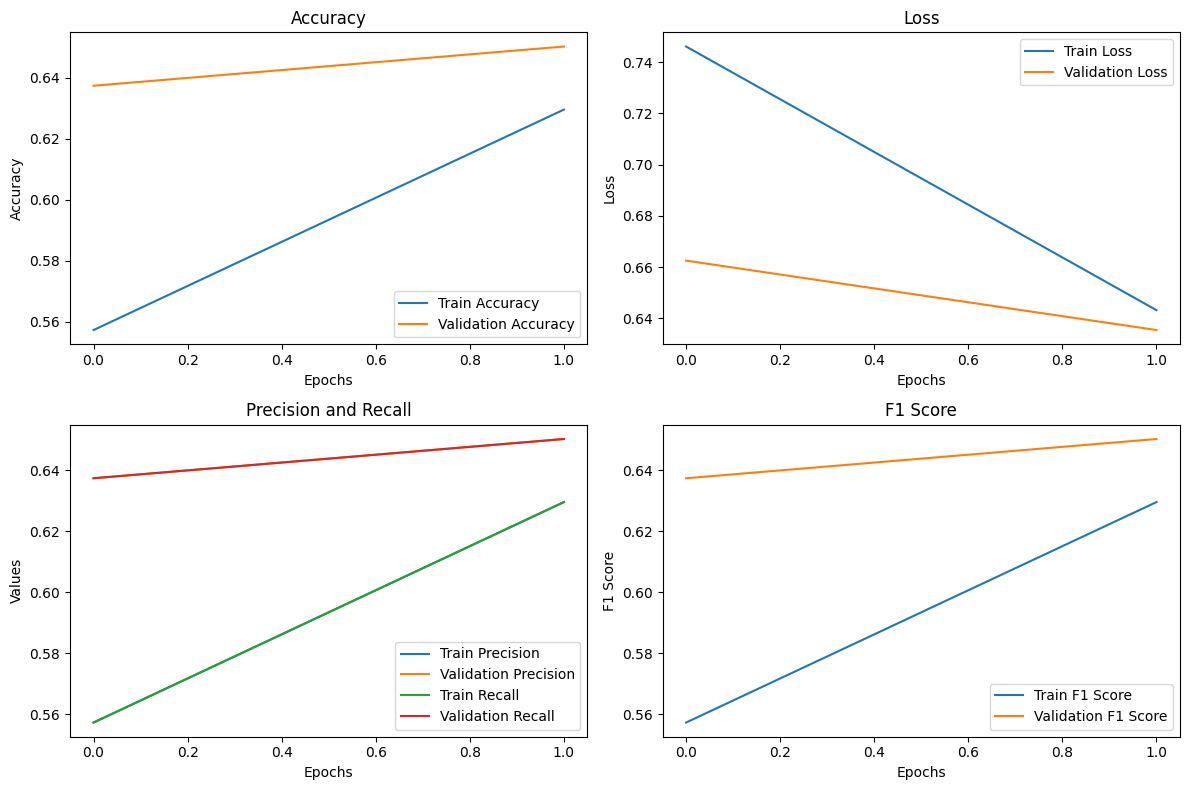

In [20]:
plot_training_history(itm.history.history)